In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler

import torch.backends.cudnn as cudnn
import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
seed = 42
torch.manual_seed(seed)

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [3]:
num_workers = 0
batch_size = 20
valid_size = 0.2

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

#Only the data is normalaized we do not need to augment the test data
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

train_data = torchvision.datasets.CIFAR10('data', train=True,
                              download=True, transform=transform_train)
test_data = torchvision.datasets.CIFAR10('data', train=False,
                             download=True, transform=transform_test)

# obtain training indices that will be used for validation
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# prepare data loaders (combine dataset and sampler)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size,
    num_workers=num_workers)

# specify the image classes
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']


100%|██████████| 170M/170M [00:04<00:00, 42.5MB/s]


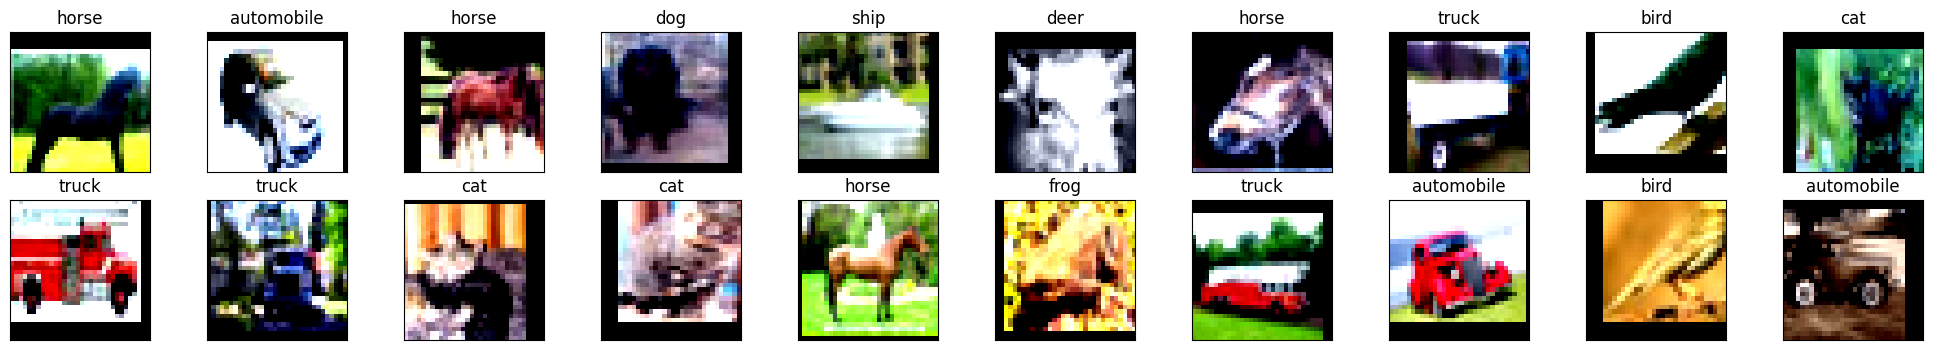

In [4]:
def imshow(img):
  img = img / 2 + 0.5  # unnormalize
  plt.imshow(np.transpose(img, (1, 2, 0)))

dataiter = iter(train_loader)
images, labels = next(dataiter)
images = images.numpy() # convert images to numpy for display

fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
  ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
  imshow(images[idx])
  ax.set_title(classes[labels[idx]])

In [5]:
class BasicBlock(nn.Module):
  expansion = 1
  def __init__(self, in_planes, planes, stride=1):
    super(BasicBlock, self).__init__()
    self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
    self.bn1 = nn.BatchNorm2d(planes)
    self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
    self.bn2 = nn.BatchNorm2d(planes)

    self.shortcut = nn.Sequential()
    if stride != 1 or in_planes != self.expansion*planes:
      self.shortcut = nn.Sequential(
          nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
          nn.BatchNorm2d(self.expansion*planes)
      )

  def forward(self, x):
    out = F.relu(self.bn1(self.conv1(x)))
    out = self.bn2(self.conv2(out))
    out += self.shortcut(x)
    out = F.relu(out)
    return out

class BottleNeck(nn.Module):
  expansion = 4

  def __init__(self, in_planes, planes, stride=1):
    super(BottleNeck, self).__init__()
    self.conv1 = nn.Conv2d(in_planes , planes, kernel_size=1, bias=False)
    self.bn1 = nn.BatchNorm2d(planes)
    self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
    self.bn2 = nn.BatchNorm2d(planes)
    self.conv3 = nn.Conv2d(planes, self.expansion*planes, kernel_size=1, bias=False)
    self.bn3 = nn.BatchNorm2d(self.expansion*planes)

    self.shortcut = nn.Sequential()
    if stride != 1 or in_planes != self.expansion*planes :
      self.shortcut = nn.Sequential(
          nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
          nn.BatchNorm2d(self.expansion*planes)
      )

  def forward(self, x):
    out = F.relu(self.bn1(self.conv1(x)))
    out = F.relu(self.bn2(self.conv2(out)))
    out = self.bn3(self.conv3(out))
    out += self.shortcut(x)
    out = F.relu(out)
    return out

class ResNet(nn.Module):
  def __init__(self, block, num_blocks, num_classes=10):
    super(ResNet, self).__init__()
    self.in_planes = 64

    self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
    self.bn1 = nn.BatchNorm2d(64)
    self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
    self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
    self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
    self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
    self.linear = nn.Linear(512*block.expansion, num_classes)

  def _make_layer(self, block, planes, num_blocks, stride):
    strides = [stride] + [1]*(num_blocks-1)
    layers = []
    for stride in strides:
      layers.append(block(self.in_planes, planes, stride))
      self.in_planes = planes * block.expansion
    return nn.Sequential(*layers)

  def forward(self, x):
    out = F.relu(self.bn1(self.conv1(x)))
    out = self.layer1(out)
    out = self.layer2(out)
    out = self.layer3(out)
    out = self.layer4(out)
    out = F.avg_pool2d(out, 4)
    out = out.view(out.size(0), -1)
    out = self.linear(out)
    return out

ResNet18 = ResNet(BasicBlock, [2,2,2,2])
#ResNet34 = ResNet(BasicBlock, [3,4,6,3])
#ResNet50 = ResNet(BottleNeck, [3,4,6,3])
#ResNet101 = ResNet(BottleNeck, [3,4,23,3])
#ResNet152 = ResNet(BottleNeck, [3,8,36,3])

print(ResNet18)

ResNet18 = torch.nn.DataParallel(ResNet18)
cudnn.benchmark = True

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=

In [6]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(ResNet18.parameters(), lr=0.01, momentum=0.9, weight_decay=0.0001)
n_epochs = 200
valid_loss_min = np.inf

In [ ]:
for epoch in range(1, n_epochs+1):
  train_loss = 0.0
  valid_loss = 0.0

  ResNet18.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    data, target = data.cuda(), target.cuda()
    optimizer.zero_grad()
    output = ResNet18(data)
    loss = criterion(output, target)
    loss.backward()
    optimizer.step()
    train_loss += loss.item()*data.size(0)

  ResNet18.eval()
  for batch_idx, (data, target) in enumerate(valid_loader):
    # move tensors to GPU if CUDA is available
    data, target = data.cuda(), target.cuda()
    output = ResNet18(data)
    loss = criterion(output, target)
    valid_loss += loss.item()*data.size(0)

  train_loss = train_loss/len(train_loader.sampler)
  valid_loss = valid_loss/len(valid_loader.sampler)

  print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
      epoch, train_loss, valid_loss))

  if valid_loss <= valid_loss_min:
    print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
    valid_loss_min,
    valid_loss))
    torch.save(ResNet18.state_dict(), 'ResNet18.pt')
    valid_loss_min = valid_loss

Epoch: 1 	Training Loss: 1.629155 	Validation Loss: 1.232524
Validation loss decreased (inf --> 1.232524).  Saving model ...
Epoch: 2 	Training Loss: 1.091231 	Validation Loss: 1.116634
Validation loss decreased (1.232524 --> 1.116634).  Saving model ...
Epoch: 3 	Training Loss: 0.854348 	Validation Loss: 0.777236
Validation loss decreased (1.116634 --> 0.777236).  Saving model ...
Epoch: 4 	Training Loss: 0.716126 	Validation Loss: 0.635028
Validation loss decreased (0.777236 --> 0.635028).  Saving model ...
Epoch: 5 	Training Loss: 0.622356 	Validation Loss: 0.584514
Validation loss decreased (0.635028 --> 0.584514).  Saving model ...
Epoch: 6 	Training Loss: 0.558455 	Validation Loss: 0.567834
Validation loss decreased (0.584514 --> 0.567834).  Saving model ...
Epoch: 7 	Training Loss: 0.503158 	Validation Loss: 0.529687
Validation loss decreased (0.567834 --> 0.529687).  Saving model ...
Epoch: 8 	Training Loss: 0.464303 	Validation Loss: 0.447522
Validation loss decreased (0.52968

In [7]:
ResNet18.load_state_dict(torch.load('ResNet18.pt'))

<All keys matched successfully>

In [10]:
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

ResNet18.eval()
for batch_idx, (data, target) in enumerate(test_loader):
  data, target = data.cuda(), target.cuda()
  output = ResNet18(data)
  loss = criterion(output, target)
  test_loss += loss.item()*data.size(0)
  _, pred = torch.max(output, 1)
  correct_tensor = pred.eq(target.data.view_as(pred))
  correct = np.squeeze(correct_tensor.cpu().numpy())
  for i in range(batch_size):
    label = target.data[i]
    class_correct[label] += correct[i].item()
    class_total[label] += 1

# average test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
  if class_total[i] > 0:
    print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
        classes[i], 100 * class_correct[i] / class_total[i],
        np.sum(class_correct[i]), np.sum(class_total[i])))
  else:
    print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.329196

Test Accuracy of airplane: 92% (920/1000)
Test Accuracy of automobile: 95% (956/1000)
Test Accuracy of  bird: 86% (862/1000)
Test Accuracy of   cat: 84% (840/1000)
Test Accuracy of  deer: 89% (896/1000)
Test Accuracy of   dog: 86% (864/1000)
Test Accuracy of  frog: 94% (946/1000)
Test Accuracy of horse: 90% (904/1000)
Test Accuracy of  ship: 94% (942/1000)
Test Accuracy of truck: 94% (948/1000)

Test Accuracy (Overall): 90% (9078/10000)


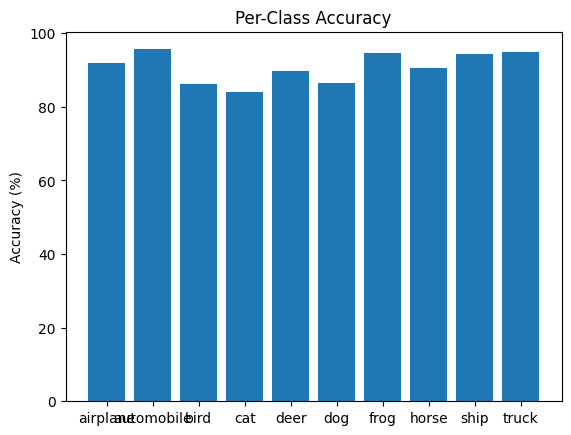

In [12]:
import matplotlib.pyplot as plt

accuracies = [100 * class_correct[i] / class_total[i] if class_total[i] > 0 else 0 for i in range(10)]

plt.bar(classes, accuracies)
plt.ylabel('Accuracy (%)')
plt.title('Per-Class Accuracy')
plt.show()
